In [2]:
import cv2 as cv
import os
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd

In [3]:
holistic_model = mp.solutions.holistic  # Holistic model to determine keypoints.
drawing_util = mp.solutions.drawing_utils  # Drawing utilities to draw keypoints.

In [4]:
def kp_detection(image, model):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # Converting image to RGB from opencv's default BGR.
    image.flags.writeable = False  # Setting image to not writable.
    result = model.process(image) # Detecting keypoints from image.
    image.flags.writeable = True   # Setting image to writable.
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR) # Converting image back to BGR from RGB.
    return image, result

In [5]:
def kp_drawing(image, results):
    # Draw face landmarks 
    drawing_util.draw_landmarks(image,
                                results.face_landmarks,
                                holistic_model.FACEMESH_CONTOURS,
                                drawing_util.DrawingSpec(color=(20,15,10), thickness=1, circle_radius=1), # Keypoint style
                                drawing_util.DrawingSpec(color=(255,255,100), thickness=1, circle_radius=1) # Keypoint connection style
                                )

    # Draw pose landmarks  
    drawing_util.draw_landmarks(image, 
                                results.pose_landmarks, 
                                holistic_model.POSE_CONNECTIONS,
                                drawing_util.DrawingSpec(color=(100,255,255), thickness=2, circle_radius=2),
                                drawing_util.DrawingSpec(color=(100,255,255), thickness=2, circle_radius=1)
                                )

    # Draw left hand landmarks
    drawing_util.draw_landmarks(image, 
                                results.left_hand_landmarks, 
                                holistic_model.HAND_CONNECTIONS,
                                drawing_util.DrawingSpec(color=(255,0,255), thickness=2, circle_radius=2),
                                drawing_util.DrawingSpec(color=(255,0,255), thickness=2, circle_radius=2)
                                )
    
    # Draw right hand landmarks 
    drawing_util.draw_landmarks(image, 
                                results.right_hand_landmarks, 
                                holistic_model.HAND_CONNECTIONS,
                                drawing_util.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2),
                                drawing_util.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2)
                                )

In [5]:
capture = cv.VideoCapture(0)
with holistic_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while capture.isOpened():
        ret, frame = capture.read()

        image, result = kp_detection(frame, holistic)

        kp_drawing(image, result)

        cv.imshow('My image', image)

        if cv.waitKey(10) & 0xFF == ord(' '):
            break

capture.release()
cv.destroyAllWindows()


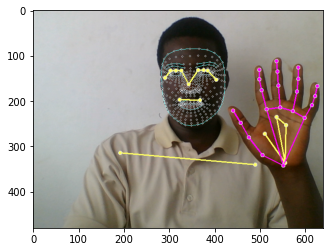

In [8]:
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [6]:
# Extracting KeyPoints 

def extract_keypoints(results):
    """ A function to extract keypoints. """

    if result.right_hand_landmarks: # If the right hand was captured.
        # Assign to 'rh' the x,y and z keypoints of each landmark and append it to an array which is then flatttened into a 1-dimensional array. 
        rh = np.array([[mark.x, mark.y, mark.z] for mark in result.right_hand_landmarks.landmark]).flatten() 
    else:
        # Assign to 'rh' an array of zeros. 
        # rh has the same size in both instances.
        rh = np.zeros(63)


    # Extracting keypoints from the left hand landmarks
    if result.left_hand_landmarks: # If the left hand was captured.
        # Assign to 'lh' the x,y and z keypoints of each landmark and append it to an array which is then flatttened into a 1-dimensional array. 
        lh = np.array([[mark.x, mark.y, mark.z] for mark in result.left_hand_landmarks.landmark]).flatten() 
    else:
        # Assign to 'lh' an array of zeros. 
        # lh has the same size in both instances.
        lh = np.zeros(63)


    # # Extracting keypoints from the face landmarks
    # if result.face_landmarks: # If the face was captured.
    #     # Assign to 'face' the x,y and z keypoints of each landmark and append it to an array which is then flatttened into a 1-dimensional array. 
    #     face = np.array([[mark.x, mark.y, mark.z] for mark in result.face_landmarks.landmark]).flatten() 
    # else:
    #     # Assign to 'face' an array of zeros. 
    #     # face has the same size in both instances.
    #     face = np.zeros(1404)


    # # Extracting keypoints from the pose landmarks
    # if result.pose_landmarks: # If the pose was captured.
    #     # Assign to 'pose' the x,y,z and visibility keypoints of each landmark and append it to an array which is then flatttened into a 1-dimensional array. 
    #     pose = np.array([[mark.x, mark.y, mark.z, mark.visibility] for mark in result.pose_landmarks.landmark]).flatten() 
    # else:
    #     # Assign to 'pose' an array of zeros. 
    #     # pose has the same size in both instances.
    #     pose = np.zeros(132)

    # return np.concatenate([pose, face, lh, rh])
    return np.concatenate([lh, rh])

In [7]:
import os
os.getcwd()

'/home/daniel/Personal/Projects/gsl'

In [8]:
signs = np.array(list('0123456789')) # Signs we would try to detect.
num_imgs = 10 

In [55]:
# Collecting Keypoint Values for Training and Testing.

capture = cv.VideoCapture(0)

f = open('dataset.csv', mode='w', newline='')
csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

with holistic_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for sign in signs:
        for img in range(num_imgs):
         
            ret, frame = capture.read() 

            # Make keypoint detection.
            image, result = kp_detection(frame, holistic)

            # Draw landmarks 
            kp_drawing(image, result)

            # Show frame in a window.
            cv.imshow("OpenCV Feed", image) 

            # Applying Wait Logic
            if img == 0:
                cv.putText(image, "STARTING COLLECTION", (120,200), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2, cv.LINE_AA)
                cv.putText(image, "Collecting frames for sign {}.  Image Number {}".format(sign, img), (12,15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv.LINE_AA)
                cv.imshow('OpenCV Feed', image) # Show to screen
                cv.waitKey(5000)
            else:
                cv.putText(image, "Collecting frames for sign {}.  Image Number {}".format(sign, img), (12,15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv.LINE_AA)
                cv.imshow('OpenCV Feed', image) # Show to screen
                cv.waitKey(3000)

            # Saving Keypoints in a csv file.
            keypoints = extract_keypoints(result)
            csv_writer.writerow(np.append(keypoints, sign))
            

            # If there is a keyup and the pressed key is the 'spacebar', break out of the loop.
            if cv.waitKey(10) & 0xFF == ord(' '): 
                break

    capture.release() # Close the video capture object 
    cv.destroyAllWindows() # Close all OpenCV windows.
f.close()

In [9]:
cols = [a+str(i) for i in range(1,43) for a in list("XYZ")]
cols.append('sign')
len(cols)

127

In [10]:
data = pd.read_csv('dataset1.csv', names=cols)
data

,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,...,X40,Y40,Z40,X41,Y41,Z41,X42,Y42,Z42,sign
0,0.763896,0.672680,-4.190000e-07,0.720447,0.593599,-0.006216,0.701082,0.526537,-0.015403,0.702353,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.764846,0.654791,-1.610000e-07,0.725597,0.592520,-0.010970,0.705608,0.531845,-0.020538,0.704495,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0.764679,0.618058,-5.780000e-08,0.723058,0.566624,-0.011630,0.704777,0.506677,-0.019525,0.704781,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,0.787223,0.620683,-8.690000e-08,0.747405,0.566939,-0.012492,0.730059,0.507945,-0.019213,0.730507,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0.801151,0.687322,-3.580000e-07,0.760647,0.652946,-0.015378,0.733706,0.593496,-0.025030,0.726534,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.781138,0.738599,3.108973e-07,0.739182,0.729265,-0.035750,0.697524,0.706750,-0.067477,0.678563,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9
696,0.820013,0.742271,3.534223e-07,0.778291,0.737673,-0.052127,0.742115,0.712120,-0.093097,0.734365,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9
697,0.813901,0.732923,5.182145e-07,0.769554,0.734930,-0.061233,0.733270,0.712278,-0.110361,0.721450,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9
698,0.806585,0.731090,5.326722e-07,0.763226,0.733053,-0.060701,0.727574,0.711906,-0.110406,0.715422,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9


In [11]:
data.shape

(700, 127)

In [12]:
data.isnull().sum()

X1      0
Y1      0
Z1      0
X2      0
Y2      0
       ..
Z41     0
X42     0
Y42     0
Z42     0
sign    0
Length: 127, dtype: int64

In [13]:
data.sign.value_counts()

0    70
1    70
2    70
3    70
4    70
5    70
6    70
7    70
8    70
9    70
Name: sign, dtype: int64

In [14]:
data.iloc[:, -1]

0      0
1      0
2      0
3      0
4      0
      ..
695    9
696    9
697    9
698    9
699    9
Name: sign, Length: 700, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size = 0.1, shuffle=True)

In [16]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
y_train.value_counts()

(630, 126) (70, 126) (630,) (70,)


8    67
6    66
3    65
9    64
4    64
1    63
7    63
0    62
5    58
2    58
Name: sign, dtype: int64

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [18]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier())
])

# parameters = {
#     "classifier__max_depth" :np.arange(1,10)
# }

# grid = GridSearchCV(pipeline, parameters, cv=2)
# grid.fit(x_train, y_train)
pipeline.fit(x_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

In [21]:
# grid.cv_results_
# grid.best_params_, grid.best_score_

In [24]:
pipeline.score(x_train, y_train)
# grid.score(x_train, y_train)

1.0

In [25]:
pipeline.predict(x_test)
# grid.predict(x_test)

array([5, 8, 2, 9, 6, 1, 2, 5, 1, 2, 4, 0, 0, 7, 5, 1, 0, 2, 7, 7, 0, 5,
       4, 5, 7, 9, 1, 2, 8, 5, 9, 8, 2, 3, 5, 2, 3, 5, 7, 3, 9, 6, 0, 5,
       4, 3, 2, 3, 9, 1, 5, 5, 2, 0, 9, 4, 4, 4, 6, 0, 5, 2, 0, 2, 7, 8,
       6, 1, 2, 2])

In [26]:
from sklearn.metrics import classification_report
y = classification_report(y_test, pipeline.predict(x_test))
# y = classification_report(y_test, grid.predict(x_test))

In [27]:
import pprint
pprint.pprint(y)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       1.00      1.00      1.00         8\n'
 '           1       1.00      0.86      0.92         7\n'
 '           2       0.85      0.92      0.88        12\n'
 '           3       0.80      0.80      0.80         5\n'
 '           4       1.00      1.00      1.00         6\n'
 '           5       1.00      1.00      1.00        12\n'
 '           6       1.00      1.00      1.00         4\n'
 '           7       1.00      0.86      0.92         7\n'
 '           8       0.75      1.00      0.86         3\n'
 '           9       1.00      1.00      1.00         6\n'
 '\n'
 '    accuracy                           0.94        70\n'
 '   macro avg       0.94      0.94      0.94        70\n'
 'weighted avg       0.95      0.94      0.94        70\n')


In [35]:
# Testing 

threshold = 0.7


capture = cv.VideoCapture(0) # Initialise the video capture object.

# While our video caputure is open, do
with holistic_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while capture.isOpened(): 
        ret, frame = capture.read() # Initialise the reading of the frame. 

        # Make keypoint detection.
        image, result = kp_detection(frame, holistic)

        # Draw landmarks 
        kp_drawing(image, result)

        # Prediction logic 
        keypoints = extract_keypoints(result)

        cla = pipeline.predict([keypoints])
        # cla = grid.predict([keypoints])

        # if pipeline.predict_proba([keypoints]).argmax() > threshold:
        #     cv.rectangle(image, (0,2), (60,40), (117,117,117), -1)
        #     cv.putText(image, str(np.array(signs)[pipeline.predict_proba([keypoints]).argmax()]), (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3, cv.LINE_AA) 
        # else : 
        #     cv.rectangle(image, (0,2), (60,40), (117,117,117), -1)
        #     cv.putText(image, "NA", (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3, cv.LINE_AA)

        cv.rectangle(image, (0,2), (60,40), (117,117,117), -1)
        cv.putText(image, str(cla[0]), (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3, cv.LINE_AA)

        # Show frame in a window.
        cv.imshow("OpenCV Feed", image) 

        # If there is a keyup and the pressed key is the 'spacebar', break out of the loop.
        if cv.waitKey(10) & 0xFF == ord(' '): 
            break

capture.release() # Close the video capture object 
cv.destroyAllWindows() # Close all OpenCV windows.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/home/daniel/Personal/Projects/gsl/gsl_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/daniel/Personal/Projects/gsl/gsl_env/lib/python3.10/site-packages/cv2/qt/plugins"
/home/daniel/Personal/Projects/gsl/gsl_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/daniel/Personal/Projects/gsl/gsl_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/daniel/Personal/Projects/gsl/gsl_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler 

In [34]:
import pickle
with open('model.pkl', 'wb') as model:
    pickle.dump(pipeline, model)

In [30]:
# pickle.loads(model)